.. index:: Solvers; Sicpy (Uzawa Saddle Point)

.. index::
   triple: Equations; Stokes; Saddle-Point;

# (Quasi) Stokes equations (Scipy based Uzawa scheme)

In [1]:
from matplotlib import pyplot
import numpy
from scipy.sparse import bmat, linalg
from dune.grid import cartesianDomain
from dune.alugrid import aluCubeGrid
from dune.fem.space import lagrange, dgonb
from dune.fem.operator import galerkin as galerkinOperator
from ufl import SpatialCoordinate, CellVolume, TrialFunction, TestFunction,\
                inner, dot, div, grad, dx, as_vector, transpose, Identity
from dune.ufl import Constant, DirichletBC
import dune.fem

muValue = 1
nuValue = 0.1
order = 2

grid = aluCubeGrid(constructor=cartesianDomain([0,0],[3,1],[30,10]))
spcU = lagrange(grid, dimRange=grid.dimension, order=order, storage="numpy")
spcP = lagrange(grid, order=order-1, storage="numpy")

x     = SpatialCoordinate(spcU)
mu    = Constant(muValue, "mu")
nu    = Constant(nuValue, "nu")
u     = TrialFunction(spcU)
v     = TestFunction(spcU)
p     = TrialFunction(spcP)
q     = TestFunction(spcP)

exact_u     = as_vector( [x[1] * (1.-x[1]), 0] )
exact_p     = (-2*x[0] + 2)*mu
f           = as_vector( [0,]*grid.dimension )
f          += nu*exact_u
dbc         = DirichletBC(spcU,exact_u)

mainModel   = (nu*dot(u,v) + mu*inner(grad(u)+grad(u).T, grad(v)) - dot(f,v)) * dx
gradModel   = -inner( p*Identity(grid.dimension), grad(v) ) * dx
divModel    = -div(u)*q * dx
massModel   = p*q * dx
preconModel = inner(grad(p),grad(q)) * dx

mainOp      = galerkinOperator( [mainModel, dbc] )
gradOp      = galerkinOperator( [gradModel, dbc] )
divOp       = galerkinOperator( divModel )
massOp      = galerkinOperator( massModel )

A = mainOp.linear()
A = A.as_numpy
def Ainv(rhs,target): target[:] = linalg.spsolve(A,rhs)
G = gradOp.linear()
G = G.as_numpy
D = divOp.linear()
D = D.as_numpy
M = massOp.linear()
M = M.as_numpy
def Minv(rhs,target): target[:] = linalg.spsolve(M,rhs)

if mainOp.model.nu > 0: # same as nu.value>0
    preconOp    = galerkinOperator( (preconModel, DirichletBC(spcP,0)), spcP)
    P = preconOp.linear().as_numpy
    def Pinv(rhs,target): target[:] = linalg.spsolve(P,rhs)

# discrete functions
velocity = spcU.interpolate(spcU.dimRange*[0], name="velocity")
pressure = spcP.interpolate(0, name="pressure")
sol_u  = velocity.as_numpy
sol_p  = pressure.as_numpy

# aux. function
rhsVelo  = velocity.copy()
rhsPress = pressure.copy()
rhs_u  = rhsVelo.as_numpy
rhs_p  = rhsPress.as_numpy
r      = numpy.copy(rhs_p)
d      = numpy.copy(rhs_p)
precon = numpy.copy(rhs_p)
xi     = numpy.copy(rhs_u)

# right hand side for Shur complement problem
mainOp(velocity,rhsVelo)
rhs_u *= -1
xi[:] = G*sol_p
rhs_u -= xi
Ainv(rhs_u[:], sol_u[:])
rhs_p[:] = D*sol_u
Minv(rhs_p, r)
if mainOp.model.nu > 0:
    precon.fill(0)
    Pinv(rhs_p, precon)
    r *= mainOp.model.mu
    r += mainOp.model.nu*precon
d[:] = r[:]
delta = numpy.dot(r,rhs_p)

# cg type iteration
for m in range(100):
    xi.fill(0)
    rhs_u[:] = G*d
    Ainv(rhs_u[:], xi[:])
    rhs_p[:] = D*xi
    rho = delta / numpy.dot(d,rhs_p)
    sol_p += rho*d
    sol_u -= rho*xi
    rhs_p[:] = D*sol_u
    Minv(rhs_p[:],r[:])
    if mainOp.model.nu > 0:
        precon.fill(0)
        Pinv(rhs_p,precon)
        r *= mainOp.model.mu
        r += mainOp.model.nu*precon
    oldDelta = delta
    delta = numpy.dot(r,rhs_p)
    print(m,delta)
    if delta < (1e-9)**2: break
    gamma = delta/oldDelta
    d *= gamma
    d += r

0 0.05083519140846924
1 0.004520464458157929
2 0.0001443814586563057


3 6.536111368146219e-06
4 3.445323821267375e-07
5 2.8767428662099426e-08
6 1.6235031965105895e-09
7 2.8276576181054936e-12


8 1.252191030596945e-13
9 9.279809692348484e-15
10 2.8894997052795626e-15


11 8.497928227560886e-17
12 2.0068997500686643e-19


Now we can easily plot the velocity magnitude and pressure

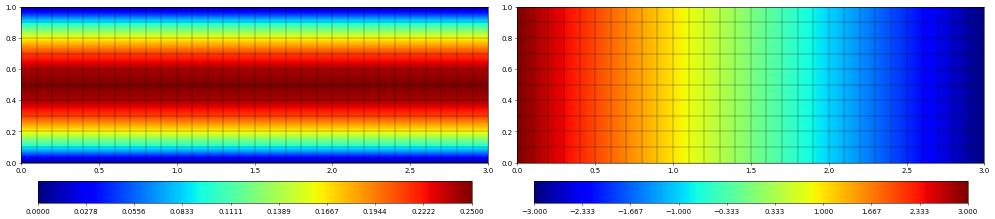

In [2]:
fig = pyplot.figure(figsize=(20,10))
velocity.plot(colorbar="horizontal", figure=(fig, 121))
pressure.plot(colorbar="horizontal", figure=(fig, 122))